In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import librosa
import librosa.display
from scipy import stats

# Завантаження даних

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATA_PATH = Path('/content/drive/MyDrive/MERGE_Bimodal_Balanced')
AUDIO_PATH = DATA_PATH / 'audio'
PROCESSED_FILE = DATA_PATH / 'processed_data_with_text_features.csv'

df = pd.read_csv(PROCESSED_FILE)

Mounted at /content/drive


# Отримання аудіо ознак

In [ ]:
def find_audio_file(audio_id, audio_path):
    for quarter_dir in audio_path.iterdir():
        if quarter_dir.is_dir():
            audio_file = quarter_dir / f"{audio_id}.mp3"
            if audio_file.exists():
                return audio_file
    return None

def extract_audio_features(audio_file, sr=22050, duration=30):
    y, sr = librosa.load(audio_file, sr=sr, duration=duration)

    features = {}

    features['duration'] = librosa.get_duration(y=y, sr=sr)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i}_std'] = np.std(mfccs[i])

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma_mean'] = np.mean(chroma)
    features['chroma_std'] = np.std(chroma)

    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spectral_centroids)
    features['spectral_centroid_std'] = np.std(spectral_centroids)

    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    features['spectral_rolloff_std'] = np.std(spectral_rolloff)

    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features['tempo'] = tempo

    zcr = librosa.feature.zero_crossing_rate(y)[0]
    features['zcr_mean'] = np.mean(zcr)
    features['zcr_std'] = np.std(zcr)

    rms = librosa.feature.rms(y=y)[0]
    features['rms_mean'] = np.mean(rms)
    features['rms_std'] = np.std(rms)

    y_harmonic, y_percussive = librosa.effects.hpss(y)

    harmonic_energy = np.sum(y_harmonic**2)
    percussive_energy = np.sum(y_percussive**2)
    features['harmonic_ratio'] = harmonic_energy / (harmonic_energy + percussive_energy)
    features['percussive_ratio'] = percussive_energy / (harmonic_energy + percussive_energy)

    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    features['mel_mean'] = np.mean(mel_spectrogram)
    features['mel_std'] = np.std(mel_spectrogram)

    return features, True

all_audio_features = []
missing_files = []
failed_files = []

for idx, row in df.iterrows():
    audio_id = row['Audio_Song']

    audio_file = find_audio_file(audio_id, AUDIO_PATH)

    if audio_file is None:
        missing_files.append(audio_id)
        all_audio_features.append({})
        continue

    features, success = extract_audio_features(audio_file)

    if success:
        all_audio_features.append(features)
    else:
        failed_files.append(audio_id)
        all_audio_features.append({})

    if (idx + 1) % 100 == 0:
        print(f"  Оброблено {idx + 1}/{len(df)} файлів")


df_audio_features = pd.DataFrame(all_audio_features)
print(f"\nДатафрейм аудіо ознак: {df_audio_features.shape}")

  Оброблено 100/2000 файлів... (Пропущено: 0, Помилки: 0)
  Оброблено 200/2000 файлів... (Пропущено: 0, Помилки: 0)
  Оброблено 300/2000 файлів... (Пропущено: 0, Помилки: 0)
  Оброблено 400/2000 файлів... (Пропущено: 0, Помилки: 0)
  Оброблено 500/2000 файлів... (Пропущено: 0, Помилки: 0)
  Оброблено 600/2000 файлів... (Пропущено: 0, Помилки: 0)
  Оброблено 700/2000 файлів... (Пропущено: 0, Помилки: 0)
  Оброблено 800/2000 файлів... (Пропущено: 0, Помилки: 0)
  Оброблено 900/2000 файлів... (Пропущено: 0, Помилки: 0)
  Оброблено 1000/2000 файлів... (Пропущено: 0, Помилки: 0)
  Оброблено 1100/2000 файлів... (Пропущено: 0, Помилки: 0)
  Оброблено 1200/2000 файлів... (Пропущено: 0, Помилки: 0)
  Оброблено 1300/2000 файлів... (Пропущено: 0, Помилки: 0)
  Оброблено 1400/2000 файлів... (Пропущено: 0, Помилки: 0)
  Оброблено 1500/2000 файлів... (Пропущено: 0, Помилки: 0)
  Оброблено 1600/2000 файлів... (Пропущено: 0, Помилки: 0)
  Оброблено 1700/2000 файлів... (Пропущено: 0, Помилки: 0)
  Обро

# Аналіз аудіо ознак

In [ ]:
іkey_features = ['tempo', 'rms_mean', 'spectral_centroid_mean',
                'harmonic_ratio', 'duration']

if all(f in df_audio_features.columns for f in key_features):
    print(df_audio_features[key_features].describe())

df_combined = pd.concat([df, df_audio_features], axis=1)

missing_audio = df_audio_features.isnull().sum()
if missing_audio.sum() > 0:
    print(missing_audio[missing_audio > 0].sort_values(ascending=False))

          rms_mean  spectral_centroid_mean  harmonic_ratio     duration
count  2000.000000             2000.000000     2000.000000  2000.000000
mean      0.149552             2148.328913        0.727529    29.811683
std       0.067758              642.297506        0.150155     0.694905
min       0.014048              490.201317        0.136720     4.752018
25%       0.097656             1655.128848        0.635344    29.880000
50%       0.135541             2148.594844        0.738949    30.000000
75%       0.198833             2632.933118        0.840568    30.000000
max       0.401457             3968.875571        0.990682    30.000000


# Візуалізація


Візуалізація 6 ознак...
Кількість рядків для візуалізації: 2000
  tempo: 2000 значень, dtype=float64


/tmp/ipython-input-1539771147.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_data, x='emotion_quadrant', y=feature,


  rms_mean: 2000 значень, dtype=float32


/tmp/ipython-input-1539771147.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_data, x='emotion_quadrant', y=feature,


  spectral_centroid_mean: 2000 значень, dtype=float64


/tmp/ipython-input-1539771147.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_data, x='emotion_quadrant', y=feature,


  harmonic_ratio: 2000 значень, dtype=float32


/tmp/ipython-input-1539771147.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_data, x='emotion_quadrant', y=feature,


  zcr_mean: 2000 значень, dtype=float64
  mfcc_0_mean: 2000 значень, dtype=float32


/tmp/ipython-input-1539771147.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_data, x='emotion_quadrant', y=feature,
/tmp/ipython-input-1539771147.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_data, x='emotion_quadrant', y=feature,


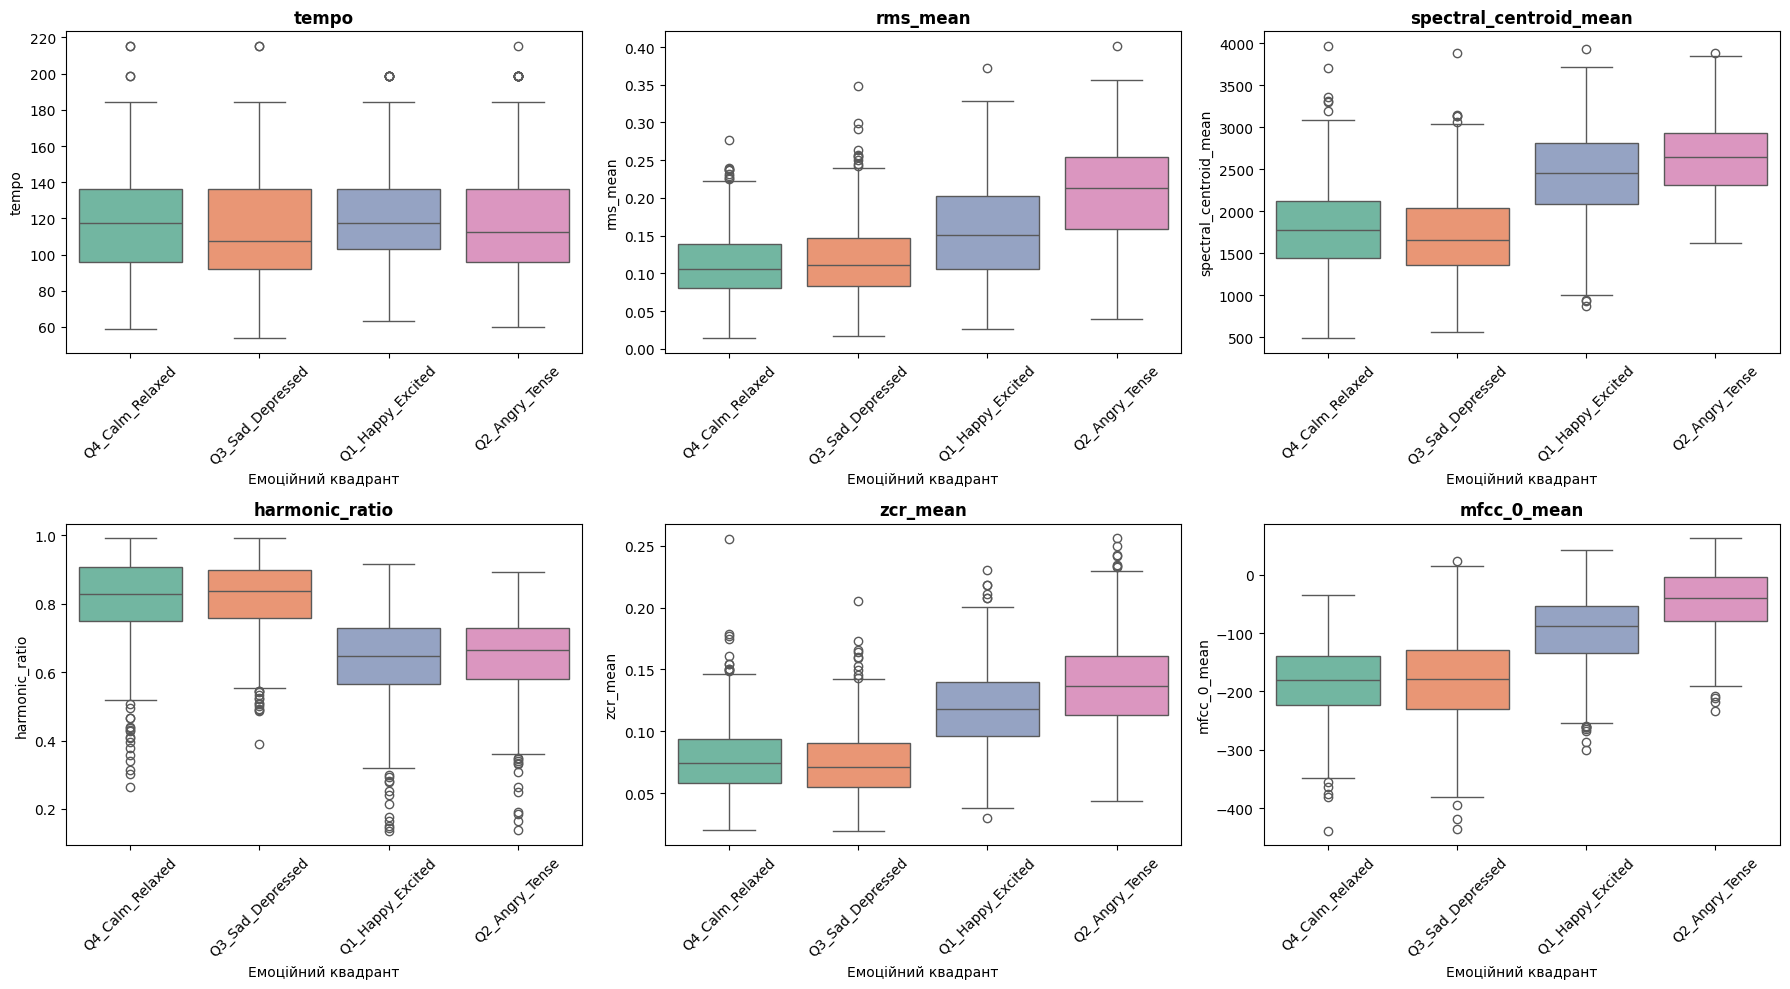

Аналіз кореляції для 51 ознак...
Залишилось 49 ознак після фільтрації

Топ-10 ознак найбільш корельованих з Arousal:
                          Arousal
mfcc_0_mean              0.552256
zcr_mean                 0.546233
chroma_mean              0.544919
spectral_centroid_mean   0.538313
harmonic_ratio          -0.532477
percussive_ratio         0.532477
spectral_rolloff_mean    0.511617
mfcc_1_mean             -0.444185
rms_mean                 0.390628
spectral_bandwidth_mean  0.372681

Топ-10 ознак найбільш корельованих з Valence:
              Valence
chroma_std   0.254946
Relevance    0.250230
chroma_mean -0.199778
rms_mean    -0.170514
mel_mean    -0.166470
mfcc_3_mean -0.150819
mfcc_12_std  0.144193
mfcc_11_std  0.139895
mfcc_7_mean -0.127364
mfcc_10_std  0.123032


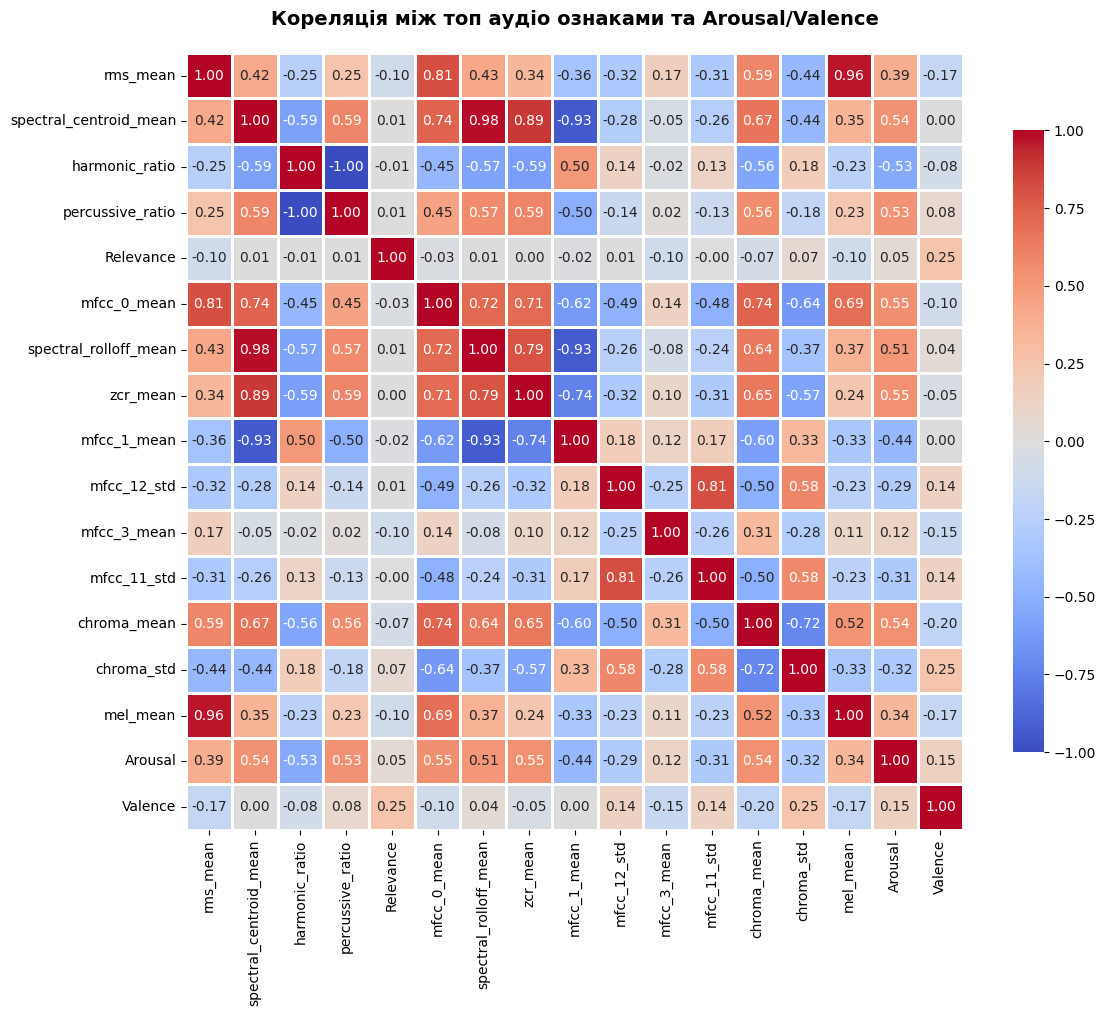

In [ ]:
def convert_to_scalar(value):
    if isinstance(value, (list, np.ndarray)):
        if len(value) > 0:
            return value[0] if np.isscalar(value[0]) else float(value[0])
        else:
            return np.nan
    return value

numeric_features = ['tempo', 'rms_mean', 'spectral_centroid_mean',
                   'harmonic_ratio', 'zcr_mean', 'mfcc_0_mean']

for feature in numeric_features:
    if feature in df_combined.columns:
        df_combined[feature] = pd.to_numeric(df_combined[feature], errors='coerce')

viz_features = ['tempo', 'rms_mean', 'spectral_centroid_mean',
                'harmonic_ratio', 'zcr_mean', 'mfcc_0_mean']

viz_features = [f for f in viz_features if f in df_combined.columns]

print(f"\nВізуалізація {len(viz_features)} ознак...")

plot_df = df_combined[['emotion_quadrant'] + viz_features].copy()
plot_df = plot_df.dropna(subset=['emotion_quadrant'])

print(f"Кількість рядків для візуалізації: {len(plot_df)}")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(viz_features[:6]):
    if idx < len(axes):
        feature_data = plot_df[['emotion_quadrant', feature]].dropna()

        if len(feature_data) > 0:
            try:
                print(f"  {feature}: {len(feature_data)} значень, "
                      f"dtype={feature_data[feature].dtype}")

                sns.boxplot(data=feature_data, x='emotion_quadrant', y=feature,
                            ax=axes[idx], palette='Set2')
                axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')
                axes[idx].set_xlabel('Емоційний квадрант', fontsize=10)
                axes[idx].set_ylabel(feature, fontsize=10)
                axes[idx].tick_params(axis='x', rotation=45)
            except Exception as e:
                print(f"   Помилка візуалізації {feature}: {e}")
                axes[idx].text(0.5, 0.5, f'Помилка:\n{feature}',
                              ha='center', va='center', transform=axes[idx].transAxes)
        else:
            print(f"  Немає даних для {feature}")

for idx in range(len(viz_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig('audio_features_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()



df_combined['Arousal'] = pd.to_numeric(df_combined['Arousal'], errors='coerce')
df_combined['Valence'] = pd.to_numeric(df_combined['Valence'], errors='coerce')
numeric_cols = df_combined.select_dtypes(include=[np.number]).columns.tolist()

exclude_cols = ['Arousal', 'Valence', 'Song_ID']
audio_numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"Аналіз кореляції для {len(audio_numeric_cols)} ознак...")

corr_data = df_combined[audio_numeric_cols + ['Arousal', 'Valence']].copy()

threshold = len(corr_data) * 0.5
corr_data = corr_data.dropna(thresh=threshold, axis=1)

print(f"Залишилось {len(corr_data.columns)-2} ознак після фільтрації")

correlations = corr_data.corr()[['Arousal', 'Valence']]
correlations = correlations.drop(['Arousal', 'Valence'], errors='ignore')

correlations['Arousal_abs'] = correlations['Arousal'].abs()
correlations['Valence_abs'] = correlations['Valence'].abs()

print("\nТоп-10 ознак найбільш корельованих з Arousal:")
top_arousal = correlations.nlargest(10, 'Arousal_abs')[['Arousal']]
print(top_arousal)

print("\nТоп-10 ознак найбільш корельованих з Valence:")
top_valence = correlations.nlargest(10, 'Valence_abs')[['Valence']]
print(top_valence)

top_features_arousal = correlations.nlargest(8, 'Arousal_abs').index.tolist()
top_features_valence = correlations.nlargest(8, 'Valence_abs').index.tolist()
top_features = list(set(top_features_arousal + top_features_valence))[:15]


corr_subset = df_combined[top_features + ['Arousal', 'Valence']].copy()
corr_matrix = corr_subset.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={'shrink': 0.8})
plt.title('Кореляція між топ аудіо ознаками та Arousal/Valence',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()



# Статистика

In [ ]:

key_stats_features = ['tempo', 'rms_mean', 'spectral_centroid_mean', 'harmonic_ratio']
key_stats_features = [f for f in key_stats_features if f in df_combined.columns]

for feature in key_stats_features:
    print(f"\n{feature}:")
    stats_by_quadrant = df_combined.groupby('emotion_quadrant')[feature].agg([
        'count', 'mean', 'std', 'min', 'max'
    ])
    print(stats_by_quadrant.round(3))


tempo:
                  count     mean     std     min      max
emotion_quadrant                                         
Q1_Happy_Excited    500  121.654  26.151  63.024  198.768
Q2_Angry_Tense      500  119.712  29.965  60.093  215.332
Q3_Sad_Depressed    500  114.124  29.932  53.833  215.332
Q4_Calm_Relaxed     500  118.621  28.412  58.727  215.332

rms_mean:
                  count   mean    std    min    max
emotion_quadrant                                   
Q1_Happy_Excited    500  0.157  0.061  0.026  0.372
Q2_Angry_Tense      500  0.209  0.066  0.039  0.401
Q3_Sad_Depressed    500  0.119  0.050  0.017  0.349
Q4_Calm_Relaxed     500  0.114  0.045  0.014  0.277

spectral_centroid_mean:
                  count      mean      std       min       max
emotion_quadrant                                              
Q1_Happy_Excited    500  2439.365  547.871   877.406  3935.350
Q2_Angry_Tense      500  2633.154  433.754  1624.727  3885.337
Q3_Sad_Depressed    500  1723.235  503.269  

# Збереження результатів

#

In [ ]:
output_file = DATA_PATH / 'processed_data_with_all_features.csv'
df_combined.to_csv(output_file, index=False)

audio_features_file = DATA_PATH / 'audio_features.csv'
df_audio_features.to_csv(audio_features_file, index=False)